# **PART I:** Sentiment analysis using LSTM [40 pts]

In this part, we perform a sentiment analysis using LSTM model. **NOTE:** The expected accuracy for this part is more than 75% for the final model.

## **Datasets**

Choose ONE dataset from the following options for sentiment analysis:

- [Amazon Product Reviews Dataset](https://www.kaggle.com/bittlingmayer/amazonreviews): reviews of various products sold on Amazon, labeled with sentiment.

- [Yelp Reviews Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset): reviews from the Yelp platform, labeled with sentiment.

- [Twitter Airline Sentiment Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment): tweets about airline experiences, labeled with sentiment.

- [Stanford Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/): movie reviews classified as positive or negative.

- [Medical Dialogue Dataset](https://www.kaggle.com/datasets/xuehaihe/medical-dialogue-dataset): contains conversations (in English) between doctors and patients. It has 0.26 million dialogues.

- [News Headlines Dataset](https://www.kaggle.com/rmisra/news-category-dataset): news headlines labeled with sentiment, covering various news topics and categories.

#### QUESTION 0
Which dataset do you choose? Briefly justify your choice (e.g., relevance to your field of study or general interest).

<font color='green'>### YOUR ANSWER HERE ###</font>

We have choosen amazom review dataset, this matchs our field of interest. There is a recent issue about fake reviews or bot review which is causing damage to customers by manupulating opinions, so we wanted to work on that problem in future and this assignment will be a good practice for us to understand and analyse the dataset.

## **TASK 1:** Data Exploration & Preprocessing

In [1]:
!pip install numpy pandas scikit-learn tensorflow tqdm matplotlib nltk seaborn pyyaml h5py

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import os
nltk.download('stopwords')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

2024-06-23 20:02:35.036886: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 20:02:36.204275: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **STEP 1:** Main Statistics

Read, preprocess, and print the main statistics about the dataset.

In [3]:
train_data = []
train_labels = []
test_data = []
test_labels = []

def load_data(path, datapoints, labels):
    with open(path, "r") as rf:
        for line in tqdm(rf.readlines()):
            label, *words = line.split()
            label = int(label.replace("__label__", "")) - 1
            datapoint = " ".join(words)
            labels.append(label)
            datapoints.append(datapoint)

load_data("train.ft.txt", train_data, train_labels)
load_data("test.ft.txt", test_data, test_labels)

100%|██████████| 400000/400000 [00:03<00:00, 110702.63it/s]


In [4]:
print(*zip(train_labels[:3], train_data[:10]), sep="\n")

(1, 'Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^')
(1, "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.")
(1, 'Amazing!: This soundtrack is my favorite mus

In [5]:
print(*zip(test_labels[:3], test_data[:10]), sep="\n")

(1, 'Great CD: My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I\'m in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life\'s hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"')
(1, "One of the best game music soundtracks - for a game I didn't really play: Despite the fact that I have only played a small portion of the game, the music I heard (plus the connection to Chrono Trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. There is an incredible mix of fun, epic, and emotional songs. Those sad and beautiful tracks I especially like, as there's not too many of those kind

In [6]:
train_df = pd.DataFrame({'label': train_labels, 'review': train_data})
test_df = pd.DataFrame({'label': test_labels, 'review': test_data})



In [7]:
# Basic statistics
print(f"Training dataset statistics : ")
print(train_df['label'].value_counts())
print(train_df['review'].apply(len).describe())
print(f"_"*150)
print(f"Test dataset statistics : ")
print(test_df['label'].value_counts())
print(test_df['review'].apply(len).describe())

Training dataset statistics : 
label
1    1800000
0    1800000
Name: count, dtype: int64
count    3.600000e+06
mean     4.316463e+02
std      2.375526e+02
min      7.200000e+01
25%      2.310000e+02
50%      3.830000e+02
75%      5.950000e+02
max      1.015000e+03
Name: review, dtype: float64
______________________________________________________________________________________________________________________________________________________
Test dataset statistics : 
label
1    200000
0    200000
Name: count, dtype: int64
count    400000.000000
mean        431.429627
std         237.435379
min          99.000000
25%         231.000000
50%         383.000000
75%         595.000000
max        1015.000000
Name: review, dtype: float64


In [8]:
train_df.head()


,label,review
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


In [9]:
test_df.head()


,label,review
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...


In [10]:
# Data preprocessing
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower().strip()
    return text

tqdm.pandas()
train_df['review'] = train_df['review'].progress_apply(clean_text)
test_df['review'] = test_df['review'].progress_apply(clean_text)


100%|██████████| 400000/400000 [00:26<00:00, 15325.36it/s]


In [11]:
train_df.head()

,label,review
0,1,stuning even for the non gamer this sound trac...
1,1,the best soundtrack ever to anything i m readi...
2,1,amazing this soundtrack is my favorite music o...
3,1,excellent soundtrack i truly like this soundtr...
4,1,remember pull your jaw off the floor after hea...


In [12]:
test_df.head()

,label,review
0,1,great cd my lovely pat has one of the great vo...
1,1,one of the best game music soundtracks for a g...
2,0,batteries died within a year i bought this cha...
3,1,works fine but maha energy is better check out...
4,1,great for the non audiophile reviewed quite a ...


#### QUESTION 1
Provide brief details about the nature of your dataset:

- 1.1 What is it about?

- 1.2 What type of data are we encountering?

- 1.3 How many entries and variables does the dataset comprise?

<font color='green'>### YOUR ANSWER HERE ###</font>



 - 1.1. This dataset is about revies of the customers on a product. We have both positive and negative reviews from a customer, we have taken this dataset from amazon

 - 1.2. We are encountering string data where the data is labeled into 1 and 0. 1 represents the positive review and 0 represents the negative review.

 - 1.3. The dataset consists of 1800000 positve reviews and 1800000 negative review in total 3600000 entries in train data and 200000 positve review 200000 negative reviews in total 400000 entries in test data. The variable here is the review that consists of text data

### **STEP 2:** Data Visualization

Using any data visualization library (e.g. [matplotlib](https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py), [seaborn](https://seaborn.pydata.org/), [plotly](https://plotly.com/python/)), provide at least 3 visualization graphs related to your dataset.

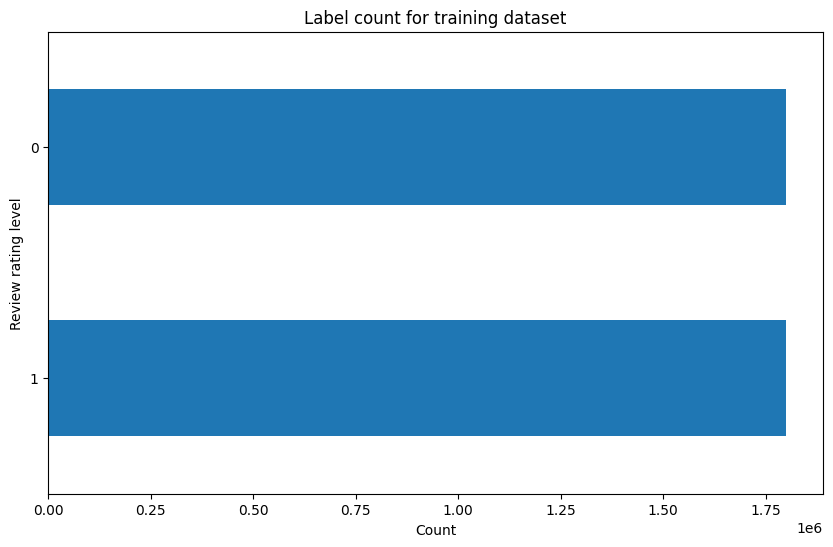

In [13]:
plot0 = train_df.label.value_counts().sort_values().plot(
    kind='barh',
    figsize=(10, 6),
    title="Label count for training dataset",
    ylabel="Review rating level",
    xlabel="Count"
)

fig = plot0.get_figure()
fig.savefig("train_label_count.png", dpi=300)

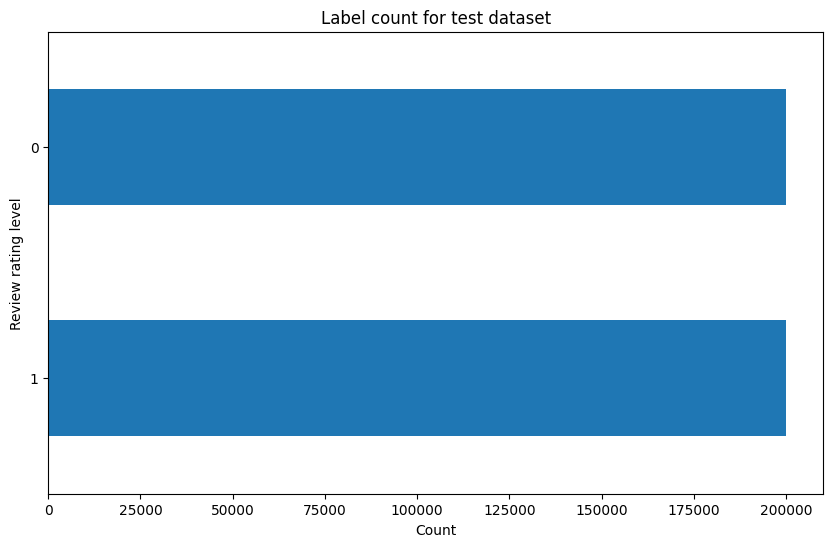

In [14]:
plot1 = test_df.label.value_counts().sort_values().plot(
    kind='barh',
    figsize=(10, 6),
    title="Label count for test dataset",
    ylabel="Review rating level",
    xlabel="Count"
)

fig = plot1.get_figure()
fig.savefig("test_label_count.png", dpi=300)

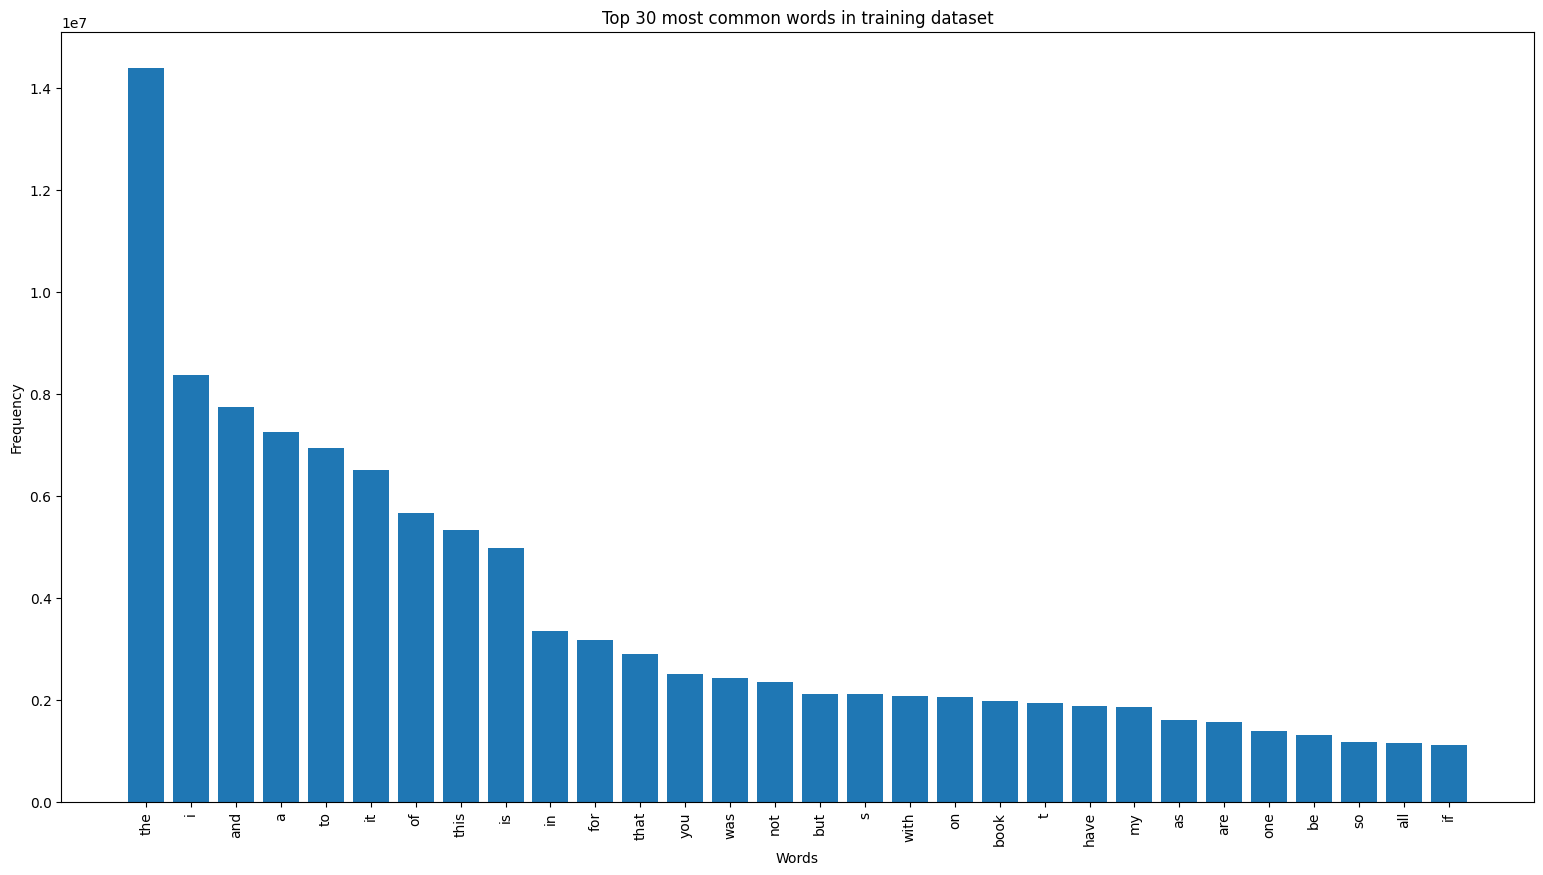

In [15]:
# Plot the top 30 most frequent words in the training dataset

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['review'])
train_sequences = tokenizer.texts_to_sequences(train_df['review'])
test_sequences = tokenizer.texts_to_sequences(test_df['review'])


word_freq = pd.DataFrame(list(tokenizer.word_counts.items()), columns=['word', 'count'])
word_freq = word_freq.sort_values('count', ascending=False).head(30)
fig = plt.figure(figsize=(19, 10))

plt.bar(word_freq['word'], word_freq['count'])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 most common words in training dataset')
plt.show()

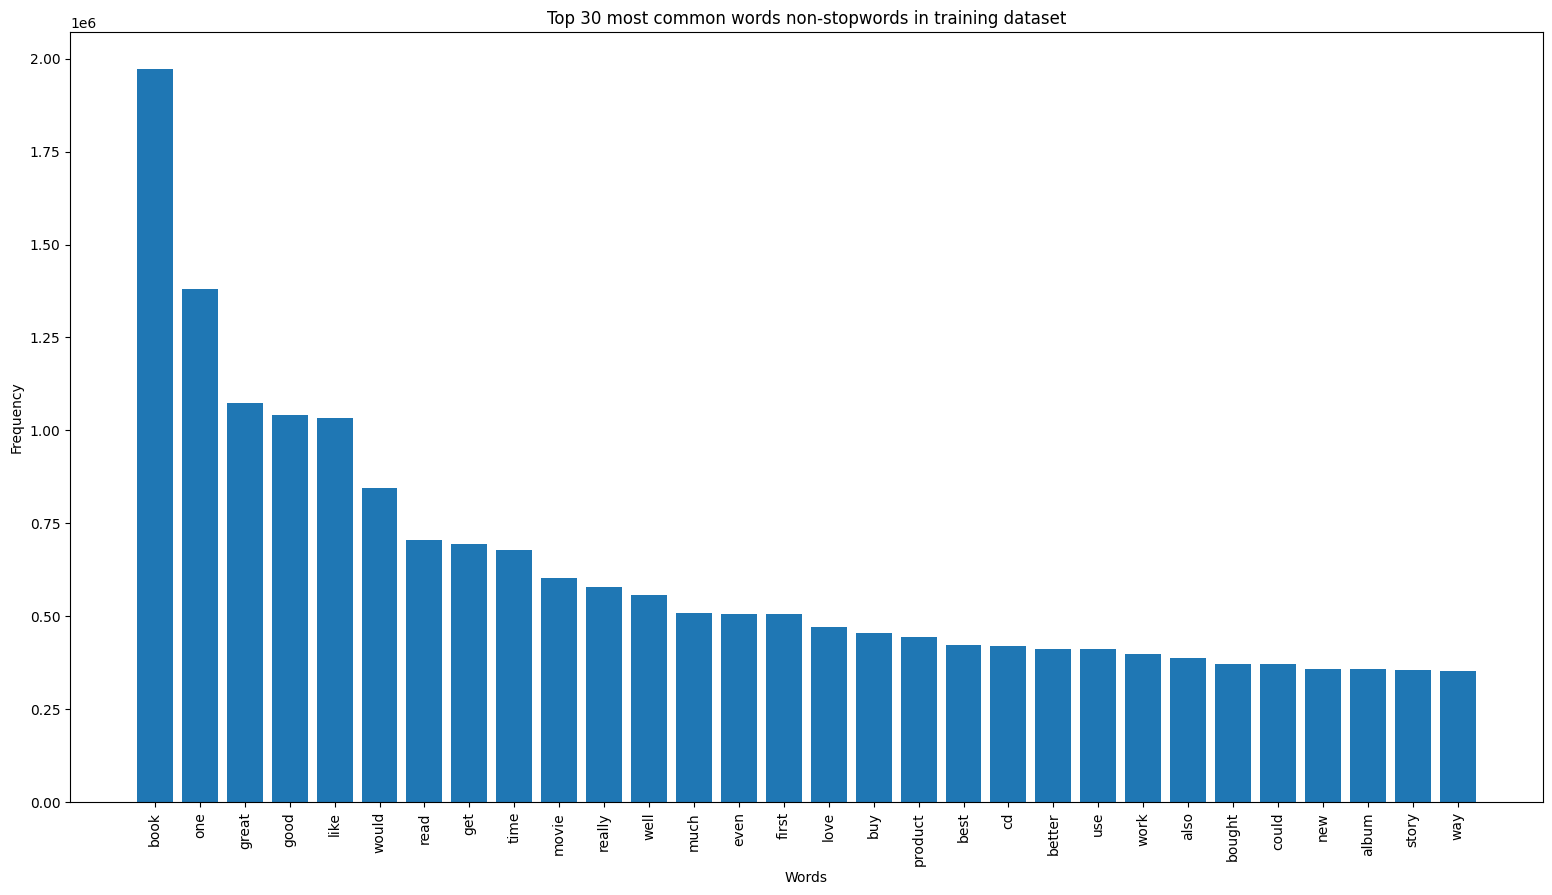

In [16]:
# Plot the top 30 most frequent words that don't appear in the stopwords list
# all_stopwords = set(stopwords.words('english'))
en_stopwords = stopwords.words('english')
es_stopwords = stopwords.words('spanish')
# print(en_stopwords)
# print(es_stopwords)
all_stopwords = set(en_stopwords + es_stopwords)

filtered_words = [word for word in tokenizer.word_counts.keys() if word not in all_stopwords]
filtered_freq = [(word, tokenizer.word_counts[word]) for word in filtered_words]
filtered_freq = sorted(filtered_freq, key=lambda x: x[1], reverse=True)[:30]
filtered_df = pd.DataFrame(filtered_freq, columns=['word', 'count'])
fig = plt.figure(figsize=(19, 10))

plt.bar(filtered_df['word'], filtered_df['count'])
plt.xticks(rotation=90)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 most common words non-stopwords in training dataset')
plt.savefig('top30freq_nonstopwords.png', dpi=300)
plt.show()

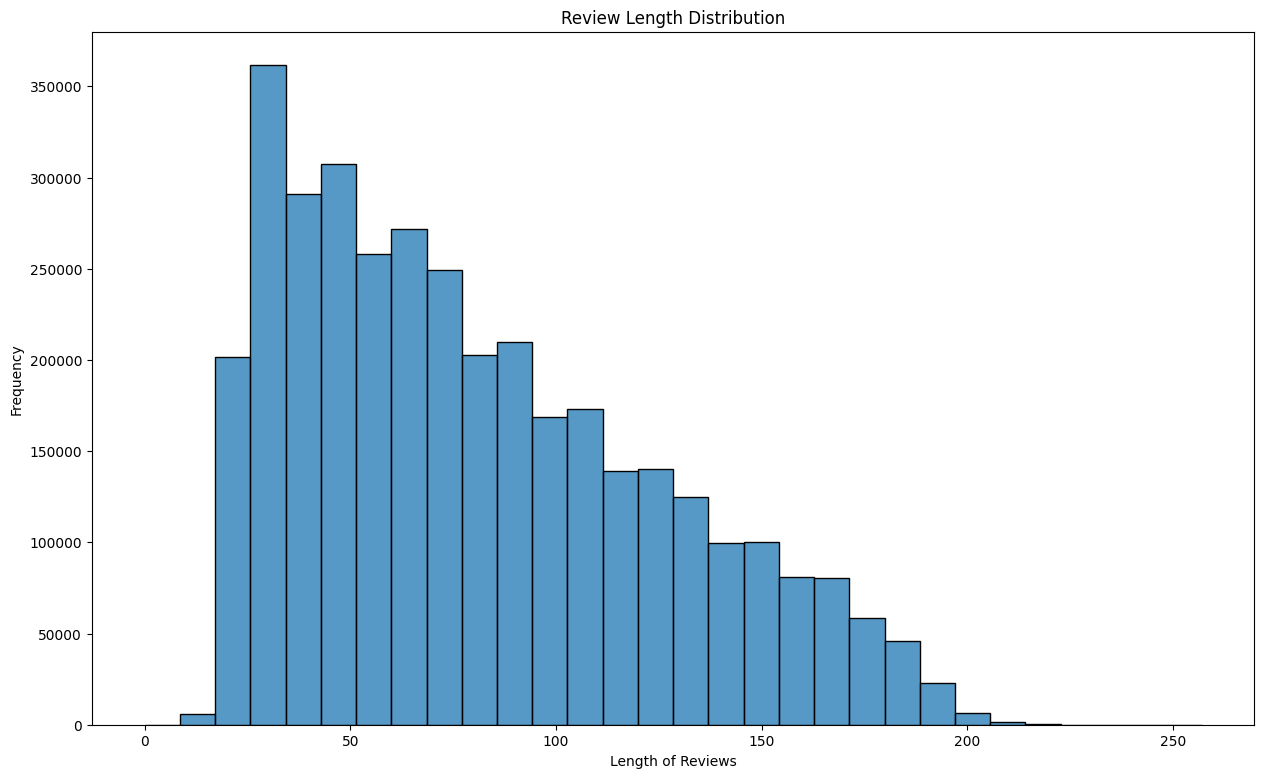

In [17]:
# Visualize review lengths
review_lengths = [len(text.split()) for text in train_df['review']]
fig = plt.figure(figsize=(15, 9))

plt.title('Review Length Distribution')
plt.xlabel('Length of Reviews')
plt.ylabel('Frequency')
sns.histplot(review_lengths, bins=30)
plt.savefig('review_len_hist.png', dpi=300)

plt.show()

### **STEP 3:** Prepare the Datasets

Example steps:

- Tokenize the text and converting it into numerical sequences

- Split it into training, validation and test sets

In [18]:
### YOUR CODE HERE ###
# Pad the sequences to have equal length
max_length = max([len(seq) for seq in train_sequences])
train_padded = pad_sequences(train_sequences, maxlen=max_length)
test_padded = pad_sequences(test_sequences, maxlen=max_length)

X_train, X_val, y_train, y_val = train_test_split(train_padded, train_df['label'], test_size=0.2, random_state=73939133)


## **TASK 2:** Build a LSTM Model

### **STEP 4:** Design an LSTM model

Build an LSTM model architecture that consists of at least three LSTM layers. You can use in-build LSTM layers, e.g. [torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)


In [19]:
GLOBAL_MODEL_DUMP = {}

In [20]:
### YOUR CODE HERE ###
base_lstm = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16, return_sequences=True),
    Dropout(0.2),
    LSTM(8),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
# base_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0004)
base_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


2024-06-23 20:16:23.534723: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-23 20:16:23.780488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-23 20:16:23.780906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [21]:
# base_lstm_history = base_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=512) #~5-6m/epoch
base_lstm_history = base_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128, callbacks=[reduce_lr]) #~16m/epoch
GLOBAL_MODEL_DUMP["base_lstm"] = (base_lstm, base_lstm_history)

Epoch 1/3


2024-06-23 20:16:25.409132: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2960640000 exceeds 10% of free system memory.
2024-06-23 20:16:34.134697: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8900


22500/22500 ━━━━━━━━━━━━━━━━━━━━ 884s 39ms/step - accuracy: 0.9227 - loss: 0.2026 - val_accuracy: 0.9516 - val_loss: 0.1318 - learning_rate: 0.0010
Epoch 2/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 863s 38ms/step - accuracy: 0.9597 - loss: 0.1166 - val_accuracy: 0.9523 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 3/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 872s 39ms/step - accuracy: 0.9697 - loss: 0.0904 - val_accuracy: 0.9518 - val_loss: 0.1435 - learning_rate: 0.0010


In [22]:
# Plot the training and validation loss & accuracy
def plot_metrics(history, savetag="base"):
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 2, i)
        plt.plot(history.history[metric], label=f'Training {metric}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'{metric.capitalize()} over epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()
    plt.savefig(f"trnVvalid_metrics_{savetag}.png", dpi=300)
    
    plt.show()


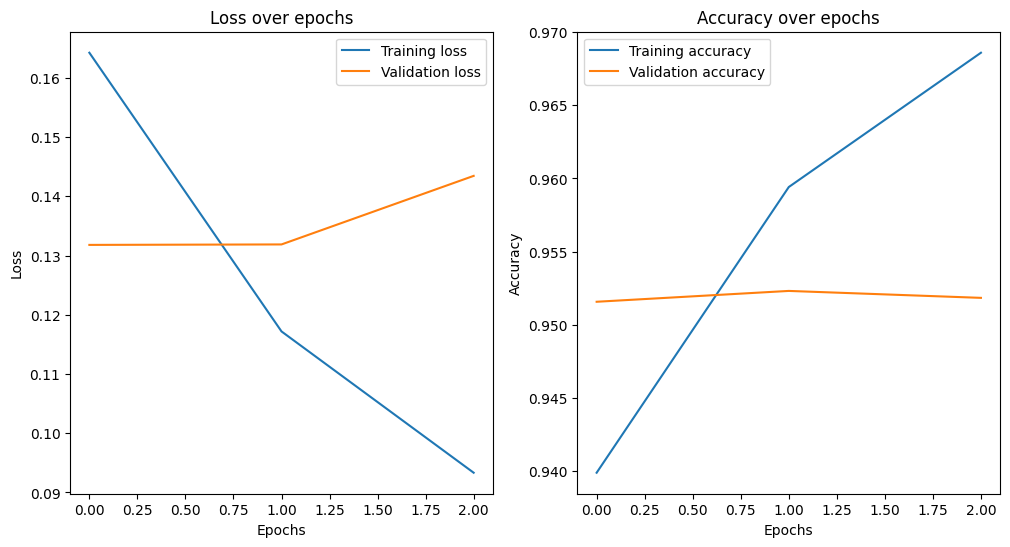

In [23]:
plot_metrics(base_lstm_history)


### **STEP 5:** Experiment with Different Settings

1. Design multiple LSTM models with various setups and hyperparameters.

2. Train the LSTM model using **the training set** and use **the validation set** to monitor the performance.

3. Plot the training loss & accuracy over epochs for each model.

4. Plot the validation loss & accuracy over epochs for each model.

While you are welcome to experiment with various hyperparameters and setup, please include the three models that return the best result.


#### EXPERIMENT #1

In [24]:

### YOUR CODE HERE ###
base_lstm_exp1 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
# base_lstm_exp1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0004)
base_lstm_exp1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# base_lstm_exp1_history = base_lstm_exp1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=512) # ~5-6m/epoch
base_lstm_exp1_history = base_lstm_exp1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=512, callbacks=[reduce_lr]) # ~m/epoch

GLOBAL_MODEL_DUMP["base_lstm_exp1"] = (base_lstm_exp1, base_lstm_exp1_history)


Epoch 1/3


2024-06-23 21:00:08.394016: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2960640000 exceeds 10% of free system memory.


5625/5625 ━━━━━━━━━━━━━━━━━━━━ 270s 47ms/step - accuracy: 0.9148 - loss: 0.2125 - val_accuracy: 0.9495 - val_loss: 0.1369 - learning_rate: 0.0010
Epoch 2/3
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 261s 46ms/step - accuracy: 0.9593 - loss: 0.1155 - val_accuracy: 0.9521 - val_loss: 0.1324 - learning_rate: 0.0010
Epoch 3/3
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 261s 46ms/step - accuracy: 0.9706 - loss: 0.0871 - val_accuracy: 0.9513 - val_loss: 0.1396 - learning_rate: 0.0010


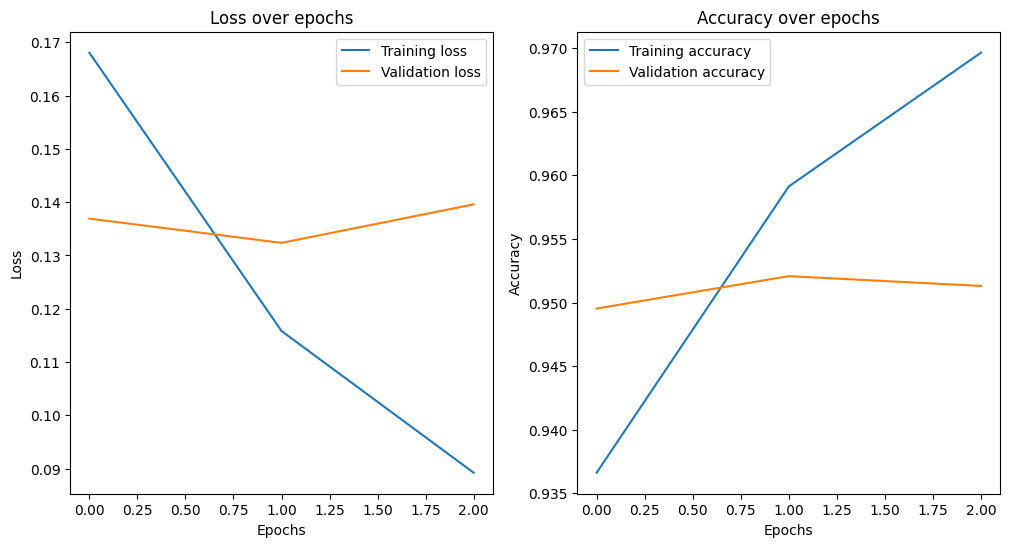

In [25]:
plot_metrics(base_lstm_exp1_history, savetag="base_lstm_exp1")


#### EXPERIMENT #2

In [26]:
### YOUR CODE HERE ###
base_lstm_exp2 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100),
    LSTM(32, return_sequences=True),
    Dropout(0.5),
    LSTM(32, return_sequences=True),
    Dropout(0.5),
    LSTM(16),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# base_lstm_exp2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0004)
base_lstm_exp2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

base_lstm_exp2_history = base_lstm_exp2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=256, callbacks=[reduce_lr])
GLOBAL_MODEL_DUMP["base_lstm_exp2"] = (base_lstm_exp2, base_lstm_exp2_history)

Epoch 1/3


2024-06-23 21:13:25.458761: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2960640000 exceeds 10% of free system memory.


11250/11250 ━━━━━━━━━━━━━━━━━━━━ 470s 41ms/step - accuracy: 0.9176 - loss: 0.2134 - val_accuracy: 0.9491 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 2/3
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 464s 41ms/step - accuracy: 0.9586 - loss: 0.1226 - val_accuracy: 0.9527 - val_loss: 0.1299 - learning_rate: 0.0010
Epoch 3/3
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 464s 41ms/step - accuracy: 0.9691 - loss: 0.0952 - val_accuracy: 0.9501 - val_loss: 0.1419 - learning_rate: 0.0010


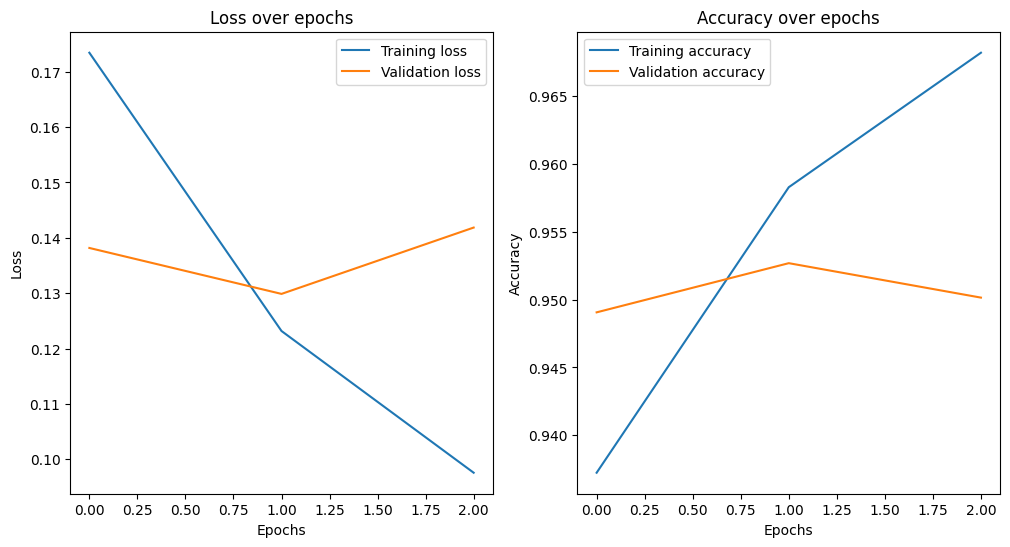

In [27]:
plot_metrics(base_lstm_exp2_history, savetag="base_lstm_exp2")


#### EXPERIMENT #3

In [28]:
### YOUR CODE HERE ###

base_lstm_exp3 = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 100),
    LSTM(16, return_sequences=True),
    Dropout(0.25),
    LSTM(16, return_sequences=True),
    Dropout(0.25),
    LSTM(16),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])
opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0004)
base_lstm_exp3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

base_lstm_exp3_history = base_lstm_exp3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128, callbacks=[reduce_lr])
GLOBAL_MODEL_DUMP["base_lstm_exp3"] = (base_lstm_exp3, base_lstm_exp3_history)

Epoch 1/3


2024-06-23 21:36:49.044592: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2960640000 exceeds 10% of free system memory.


22500/22500 ━━━━━━━━━━━━━━━━━━━━ 889s 39ms/step - accuracy: 0.9234 - loss: 0.1975 - val_accuracy: 0.9508 - val_loss: 0.1332 - learning_rate: 0.0010
Epoch 2/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 882s 39ms/step - accuracy: 0.9593 - loss: 0.1171 - val_accuracy: 0.9521 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 3/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 879s 39ms/step - accuracy: 0.9687 - loss: 0.0929 - val_accuracy: 0.9503 - val_loss: 0.1403 - learning_rate: 0.0010


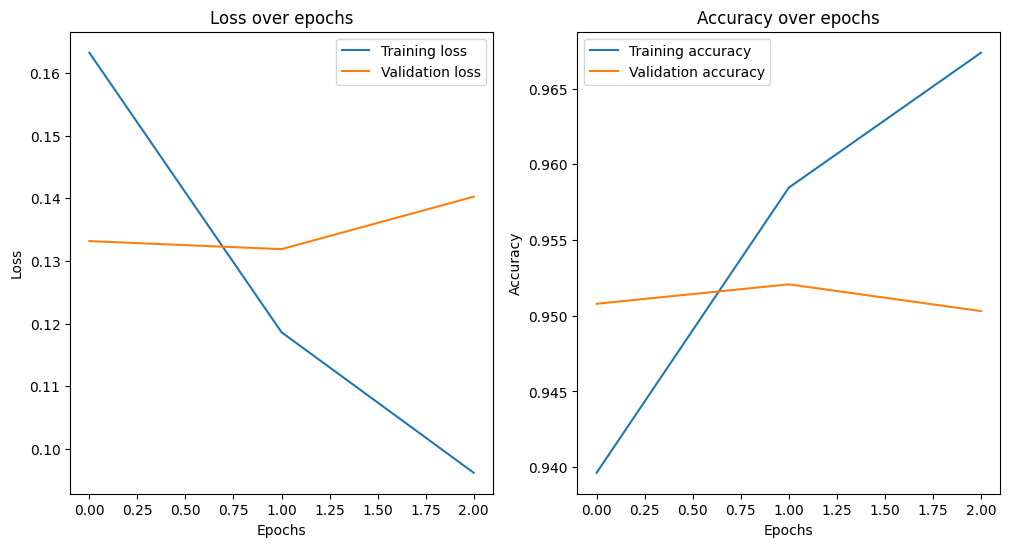

In [29]:
plot_metrics(base_lstm_exp3_history, savetag="base_lstm_exp3")


### **STEP 6:** Evaluate the Models

1. Compare the performance of the three models based on the metrics obtained from the validation set.

2. Save the weights of the final model that returns best results.

3. Evaluate the best model using **the test set**.

4. Report the loss & accuracy of the best model on the test set.

5. Generate a confusion matrix using the predictions on the test set.

In [30]:
max_valacc_tag = ""
best_model = None
max_valacc = 0

for model_name, (model, model_history) in GLOBAL_MODEL_DUMP.items():
    val_accuracies = model_history.history["val_accuracy"]
    avg_val_acc = sum(val_accuracies)/len(val_accuracies)
    if avg_val_acc > max_valacc:
        max_valacc = avg_val_acc
        max_valacc_tag = model_name
        best_model = model
print(max_valacc_tag)
print(max_valacc)


base_lstm
0.9519176085789999


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 128s 10ms/step - accuracy: 0.9499 - loss: 0.1488
LSTM Model - Test Loss: 0.1442, Test Accuracy: 0.9514
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 117s 9ms/step
LSTM Model Confusion Matrix:
[[190044   9956]
 [  9470 190530]]


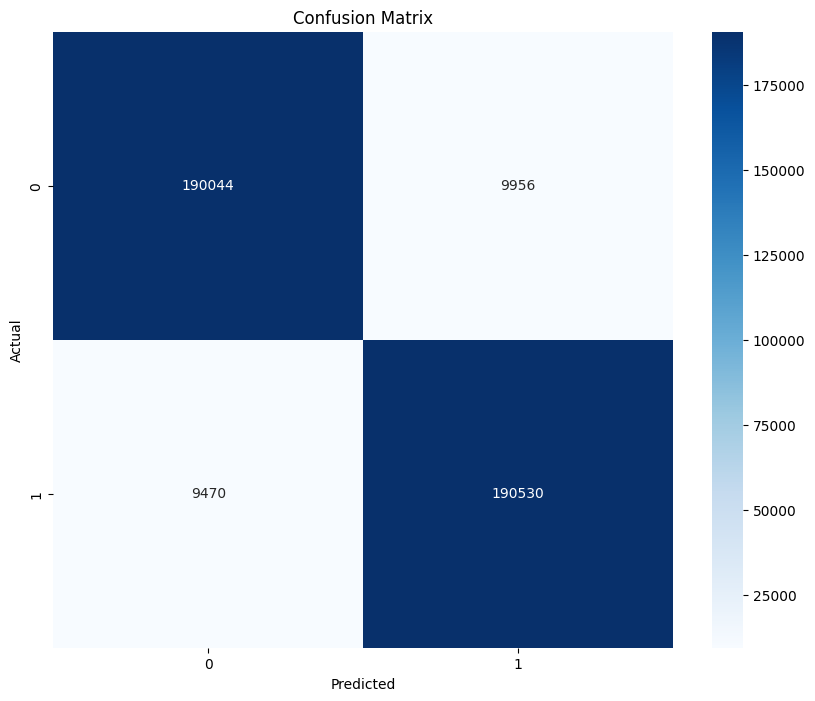

In [31]:
### YOUR CODE HERE ###
lstm_loss, lstm_accuracy = best_model.evaluate(test_padded, test_df['label'])
print(f'LSTM Model - Test Loss: {lstm_loss:.4f}, Test Accuracy: {lstm_accuracy:.4f}')

# Generate the confusion matrix for the LSTM model
lstm_predictions = best_model.predict(test_padded) > 0.5
lstm_cm = confusion_matrix(test_df['label'], lstm_predictions)
print('LSTM Model Confusion Matrix:')
print(lstm_cm)


fig = plt.figure(figsize=(10, 8))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('best_lstm_model_confmat.png', dpi=300)
plt.show()

#### QUESTION 2
Provide the details related to your LSTM architecture that returns the best result.

<font color='green'>### YOUR ANSWER HERE ###</font>

We are using 3 stacked LSTM layers, 1 Embedding layer, 3 dropout layers to drop 50% neurons and finally 1 fully connected dense layer. Embedded layer is used to convert input token Id into dense vectors of fixed size. We are using unidirectional LSTM as part of our initial (unimproved version), the final fully connected layer will have sigmoid activation to give us 0 or 1 as we are dealing with classification problem.

Using this architecture we can capture long range dependencies in forward direction.



#### QUESTION 3
Analyze the graphs and results obtained during the training, validation, and test steps.

<font color='green'>### YOUR ANSWER HERE ###</font>


We have designed 4 models in total. The base model and 3 experiment models, the base model has got the better accuracy when compared to 3 other experimental models. In the base model the loss curve has gone down significantly after the first epoch and in the same style the accuracy curve has gone up. This indicates that this model is performing good.

step - accuracy: 0.9697 - loss: 0.0904 - val_accuracy: 0.9518 - val_loss: 0.1435 - learning_rate: 0.0010

When it comes to the experimental models, they also performed good but we are choosing the models based on the best validation accuracy recieved during the training.

The testing of our best model: The testing of our best model has given  accuracy: 0.9499 - loss: 0.1488 and we can see it is having good prediction of both positive and negative predictions. The confusion matrix tells us that both True positives and True negatives and balanced so this is the best model

## **TASK 3:** Build an Improved LSTM Model

### **STEP 7:** Design an Improved LSTM Model

Use any other version of LSTM model architecture to improve the results, e.g., Gated Recurrent Unit (GRU), Bidirectional LSTM, Stacked LSTM.

In [32]:
### YOUR CODE HERE ###

improv_model = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 100),
        Bidirectional(LSTM(16, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(16, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(8)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
# improv_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0004)
improv_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [33]:
base_improv_history = improv_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=256, callbacks=[reduce_lr])

GLOBAL_MODEL_DUMP["improv"] = (improv_model, base_improv_history)

Epoch 1/3


2024-06-23 22:25:35.928265: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2960640000 exceeds 10% of free system memory.


11250/11250 ━━━━━━━━━━━━━━━━━━━━ 707s 62ms/step - accuracy: 0.9133 - loss: 0.2233 - val_accuracy: 0.9488 - val_loss: 0.1383 - learning_rate: 0.0010
Epoch 2/3
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 701s 62ms/step - accuracy: 0.9597 - loss: 0.1163 - val_accuracy: 0.9526 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 3/3
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 705s 63ms/step - accuracy: 0.9709 - loss: 0.0878 - val_accuracy: 0.9496 - val_loss: 0.1425 - learning_rate: 0.0010


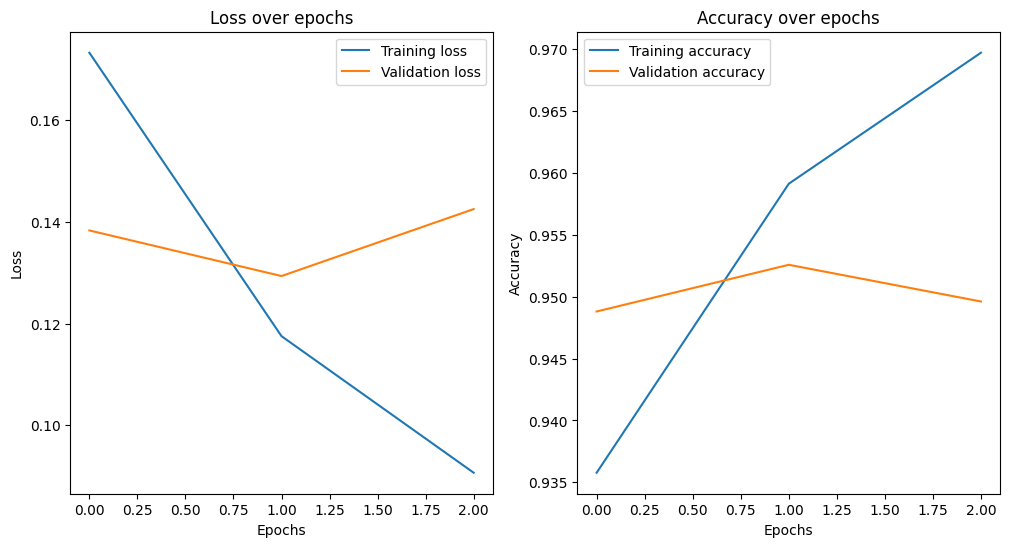

In [34]:
plot_metrics(base_improv_history, savetag="improv")


### **STEP 8:** Experiment with Different Settings

1. Design multiple improved LSTM models with various setups and hyperparameters.

2. Train the improved models using **the training set** and use **the validation set** to monitor the performance.

3. Plot the training loss & accuracy over epochs for each model.

4. Plot the validation loss & accuracy over epochs for each model.

While you are welcome to experiment with various hyperparameters and setup, please include the three models that return the best result.


#### EXPERIMENT #1

In [35]:
### YOUR CODE HERE ###

improv_model_exp1 = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 100),
        GRU(32, return_sequences=True),
        Dropout(0.2),
        GRU(16, return_sequences=True),
        Dropout(0.25),
        GRU(8),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
# improv_model_exp1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0004)
improv_model_exp1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

In [36]:
improv_exp1_history = improv_model_exp1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128, callbacks=[reduce_lr])

GLOBAL_MODEL_DUMP["improv_exp1"] = (improv_model_exp1, improv_exp1_history)

Epoch 1/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 880s 39ms/step - accuracy: 0.9237 - loss: 0.1974 - val_accuracy: 0.9532 - val_loss: 0.1293 - learning_rate: 0.0010
Epoch 2/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 876s 39ms/step - accuracy: 0.9614 - loss: 0.1118 - val_accuracy: 0.9535 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 3/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 872s 39ms/step - accuracy: 0.9721 - loss: 0.0846 - val_accuracy: 0.9506 - val_loss: 0.1436 - learning_rate: 0.0010


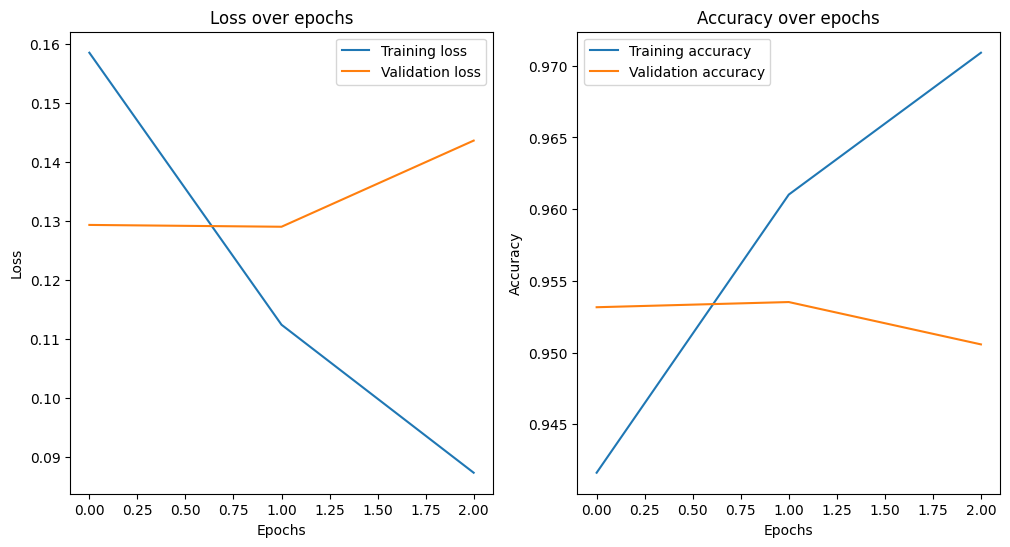

In [37]:
plot_metrics(improv_exp1_history, savetag="improv_exp1")


#### EXPERIMENT #2

In [38]:
### YOUR CODE HERE ###

improv_model_exp2 = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 100),
        Bidirectional(GRU(16, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(GRU(16, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(GRU(16)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
# improv_model_exp2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
opt = tf.keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0004)
improv_model_exp2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [39]:
improv_exp2_history = improv_model_exp2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=128, callbacks=[reduce_lr])

GLOBAL_MODEL_DUMP["improv_exp2"] = (improv_model_exp2, improv_exp2_history)

Epoch 1/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 1272s 56ms/step - accuracy: 0.9209 - loss: 0.2044 - val_accuracy: 0.9525 - val_loss: 0.1291 - learning_rate: 0.0010
Epoch 2/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 1293s 57ms/step - accuracy: 0.9608 - loss: 0.1126 - val_accuracy: 0.9537 - val_loss: 0.1297 - learning_rate: 0.0010
Epoch 3/3
22500/22500 ━━━━━━━━━━━━━━━━━━━━ 1306s 58ms/step - accuracy: 0.9711 - loss: 0.0862 - val_accuracy: 0.9509 - val_loss: 0.1421 - learning_rate: 0.0010


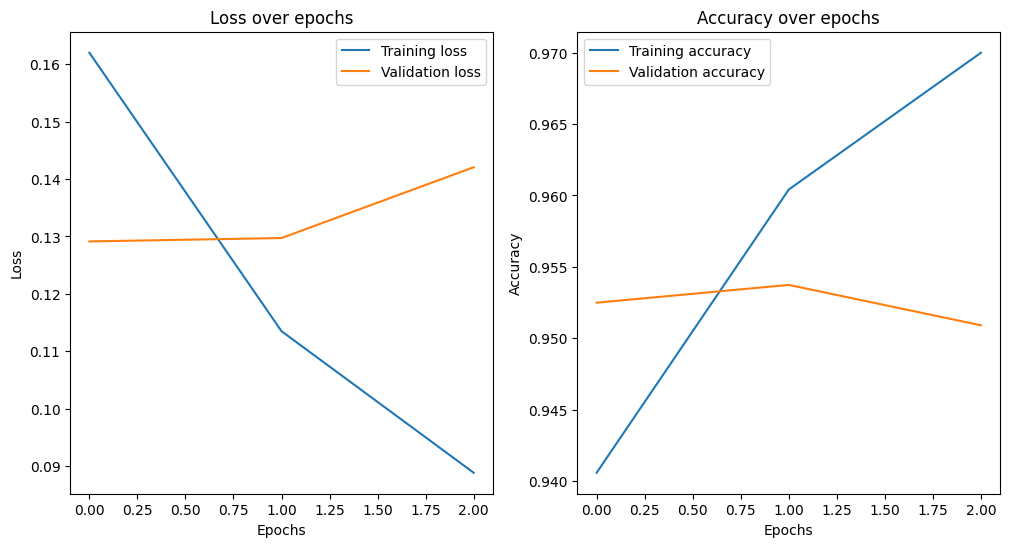

In [40]:
plot_metrics(improv_exp2_history, savetag="improv_exp2")


#### EXPERIMENT #3

In [41]:
### YOUR CODE HERE ###

improv_model_exp3 = Sequential([
        Embedding(len(tokenizer.word_index) + 1, 100),
        Bidirectional(LSTM(16, return_sequences=True)),
        Dropout(0.25),
        GRU(16, return_sequences=True),
        Dropout(0.2),
        Bidirectional(GRU(16)),
        Dropout(0.25),
        Dense(1, activation='sigmoid')
    ])
# improv_model_exp3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
opt = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0004)
improv_model_exp3.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [42]:
improv_exp3_history = improv_model_exp3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=256, callbacks=[reduce_lr])

GLOBAL_MODEL_DUMP["improv_exp3"] = (improv_model_exp3, improv_exp3_history)

Epoch 1/3
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 598s 53ms/step - accuracy: 0.8766 - loss: 0.2884 - val_accuracy: 0.9289 - val_loss: 0.1832 - learning_rate: 1.0000e-04
Epoch 2/3
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 604s 54ms/step - accuracy: 0.9387 - loss: 0.1644 - val_accuracy: 0.9407 - val_loss: 0.1563 - learning_rate: 1.0000e-04
Epoch 3/3
11250/11250 ━━━━━━━━━━━━━━━━━━━━ 590s 52ms/step - accuracy: 0.9512 - loss: 0.1352 - val_accuracy: 0.9432 - val_loss: 0.1515 - learning_rate: 1.0000e-04


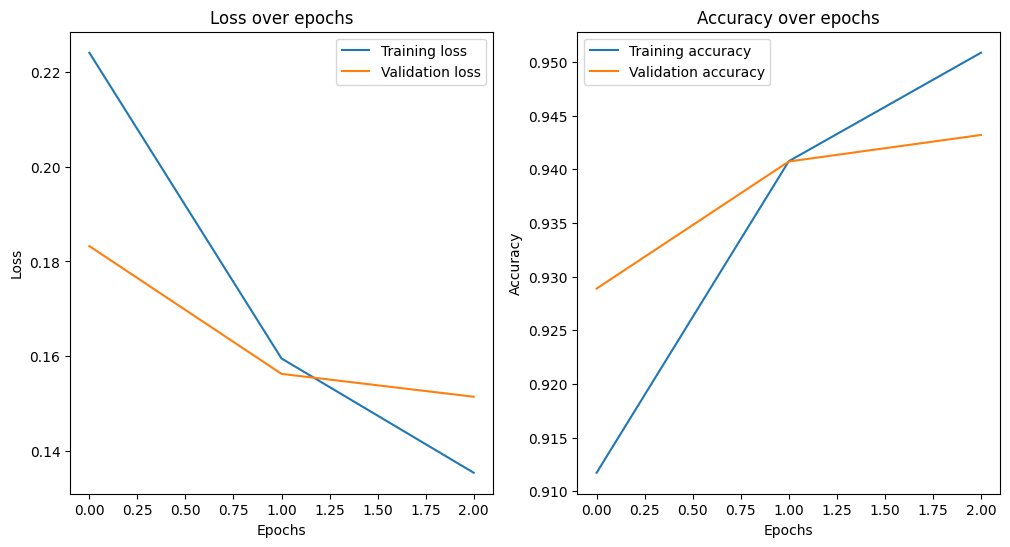

In [43]:
plot_metrics(improv_exp3_history, savetag="improv_exp3")


### **STEP 9:** Evaluate the Improved Models

1. Compare the performance of the three improved models based on the metrics obtained from the validation set.

2. Save the weights of the final improved model that returns best results.

3. Evaluate the best improved model using **the test set**.

4. Report the loss & accuracy of the best improved model on the test set.

5. Generate a confusion matrix using the predictions on the test set.

In [44]:
### YOUR CODE HERE ###
max_valacc_tag = ""
best_improvmdel = None
max_valacc = 0

for model_name, (model, model_history) in GLOBAL_MODEL_DUMP.items():
    if "base" in model_name:
        continue
    val_accuracies = model_history.history["val_accuracy"]
    avg_val_acc = sum(val_accuracies)/len(val_accuracies)
    if avg_val_acc > max_valacc:
        max_valacc = avg_val_acc
        max_valacc_tag = model_name
        best_improvmdel = model
print(max_valacc_tag)
print(max_valacc)


improv_exp1
0.952418049176534


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 115s 9ms/step - accuracy: 0.9493 - loss: 0.1483
Improved model - Test Loss: 0.1449, Test Accuracy: 0.9505
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 102s 8ms/step
Improved Model Confusion Matrix:
[[189348  10652]
 [  9166 190834]]


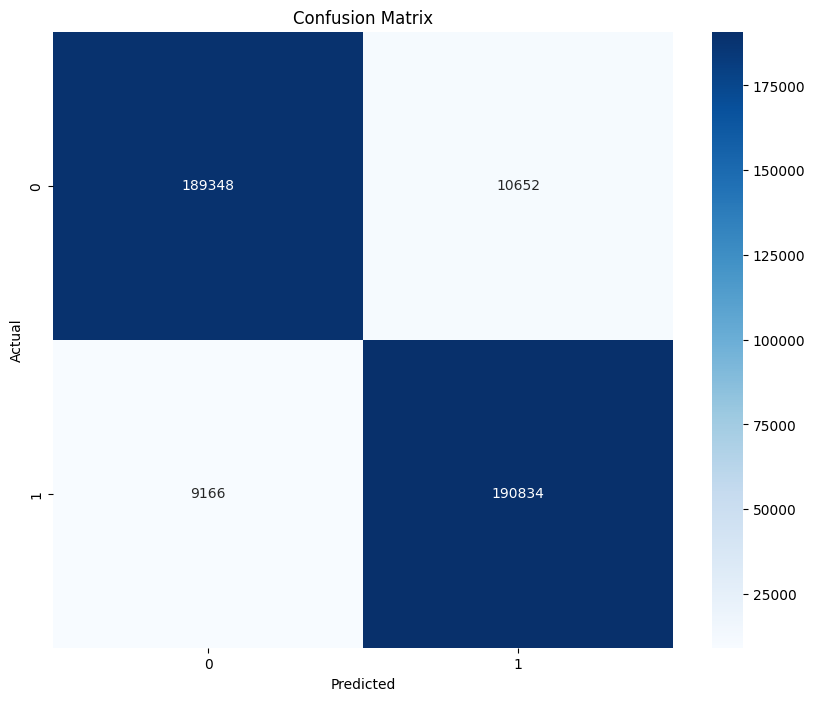

In [45]:
### YOUR CODE HERE ###
improvmdel_loss, improvmdel_accuracy = best_improvmdel.evaluate(test_padded, test_df['label'])
print(f'Improved model - Test Loss: {improvmdel_loss:.4f}, Test Accuracy: {improvmdel_accuracy:.4f}')

improvmdel_predictions = best_improvmdel.predict(test_padded) > 0.5
improvmdel_cm = confusion_matrix(test_df['label'], improvmdel_predictions)
print('Improved Model Confusion Matrix:')
print(improvmdel_cm)

fig = plt.figure(figsize=(10, 8))
sns.heatmap(improvmdel_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('best_improv_model_confmat.png', dpi=300)
plt.show()

#### Save all the model weights

In [46]:
for model_tag, (model_, *_) in GLOBAL_MODEL_DUMP.items():
    model_.save(f'chaudhu2_ssheri_assignment2_part1_{model_tag}.h5')

#### QUESTION 4
Provide the details related to your improved LSTM architecture that returns the best accuracy.

<font color='green'>### YOUR ANSWER HERE ###</font>



In the improved LSTM architecture we are using a bidirectional LSTM, GRU and hybrid model combining both. The best model among them is GRU the experiment 1.

There is an Embedding layer which will help us to encode words in vectors. There are three GRU layers followed by a dense layer. The first GRU layer consists of 32 neurons which will output complete sequence of outputs, it is followed by a 0.2 dropout. 
The second GRU layer has 16 neurons which will take the 32 output from first layer and output 16 features with a dropout of 0.25.

The third GRU layer will take the 16 features and bring them down to 8 features with dropout of 0.2 and outputs the features to final dense layer.

The final dense layer will have only one neuron with sigmoid activation function, it will detect us weather the review is positive or negative

#### QUESTION 5
Analyze the graphs and results obatined during the training, validation, and test steps.

<font color='green'>### YOUR ANSWER HERE ###</font>



We have build 4 models. 1 base model and 3 experimental models. All of our models have good performance on the dataset, as this is improved LSTM the accuracy is acheived very quickly. We are having fastly decreasing loss curve after first epoch and out accuracy curve is going up in the same way.

We have choose our improved experiment 1 model as the best performing model amongst all the models trained.

Validation Accuracy: 95.24% and Testing accuracy of  0.9505

The confusion matrix tells us that the prediction is equally good for both positive and negative reviews. 

#### QUESTION 6
Compare the performance of the LSTM model and the improved LSTM model applied to the same dataset.

<font color='green'>### YOUR ANSWER HERE ###</font>


The performance of Improved LSTM is good when compared to one directional LSTM. Improved LSTM (GRU, Bidirectional LSTM, Hybird) these models are better compared to LSTM, due to less number of gates GRU is computationally good and also converging faster. 
When we use bidirectional LSTM it is little expensive computationally but it captures better patterns as we move both forward and backward, the meaning of the word will also depend on the future words.
So the improved LSTM will give better results when compared to the vannila LSTM

#### QUESTION 7
Discuss the strengths and limitations of using recurrent neural models for sentiment analysis.

<font color='green'>### YOUR ANSWER HERE ###</font>


RNN is very helpful in capturing long range dependencies in the text, we don't need to change the model according to the text size. It learn's contextual representation of words. 

RNN possess vanishing and exploding gradient issues, it will forget the first information when the input sequence is very long. RNN's are not practically suitable when the sequences are very long.

RNN is good for sentiment analysis but there performance decreases when they are used for very long text in practical scenarios. 


## **References**

Include all the references that have been used to complete the assignment.

<font color='green'>### YOUR ANSWER HERE ###</font>

 - https://keras.io/examples/nlp/text_classification_from_scratch/
 - https://www.tensorflow.org/tutorials/keras/text_classification
 - https://towardsdatascience.com/an-easy-tutorial-about-sentiment-analysis-with-deep-learning-and-keras-2bf52b9cba91
 - https://www.kaggle.com/code/ngyptr/lstm-sentiment-analysis-keras
 - https://keras.io/api/keras_nlp/tokenizers/tokenizer/
 - https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
 - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
 - https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional